In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
torch.__version__

'1.13.1+cpu'

In [2]:
torch.manual_seed(123)

In [2]:
transform = transforms.ToTensor()
train = datasets.MNIST(root = '.', train = True, download = True, 
                       transform = transform)
train_loader = torch.utils.data.DataLoader(train, batch_size = 256)

In [5]:
train[0][0].shape

torch.Size([1, 28, 28])

In [81]:
# Define o gerador
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 7*7*128)
        self.conv1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = x.view(-1, 128, 7, 7)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = torch.tanh(self.conv2(x))
        return x

In [82]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.fc1 = nn.Linear(128*7*7, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = x.view(-1, 128*7*7)
        x = torch.sigmoid(self.fc1(x))
        return x

In [83]:
G = Generator()
D = Discriminator()

In [84]:
G_optimizer = optim.Adam(G.parameters(), lr = 0.002)
D_optimizer = optim.Adam(D.parameters(), lr = 0.002)

In [85]:
criterion = nn.BCEWithLogitsLoss()

In [86]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

In [87]:
device = 'cpu'

In [88]:
G.to(device)

Generator(
  (fc1): Linear(in_features=100, out_features=6272, bias=True)
  (conv1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [89]:
D.to(device)

Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=6272, out_features=1, bias=True)
)

ÉPOCA 001 finalizada: custo discriminador 1.376964 - custo gerador 0.691608      


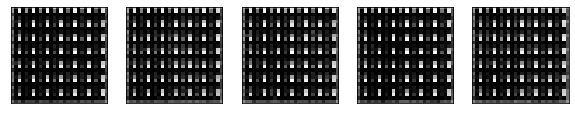

ÉPOCA 002 finalizada: custo discriminador 1.386294 - custo gerador 0.693147      


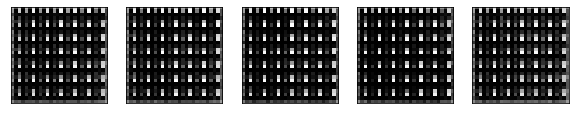

ÉPOCA 003 finalizada: custo discriminador 1.386294 - custo gerador 0.693147      


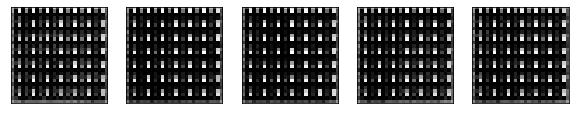

ÉPOCA 004 finalizada: custo discriminador 1.386294 - custo gerador 0.693147      


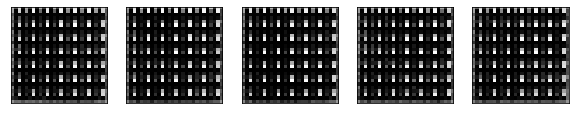

ÉPOCA 005 finalizada: custo discriminador 1.386294 - custo gerador 0.693147      


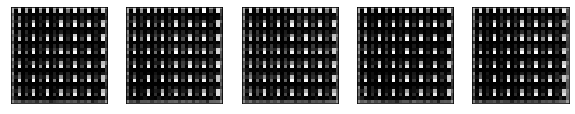

ÉPOCA 006 finalizada: custo discriminador 1.386294 - custo gerador 0.693147      


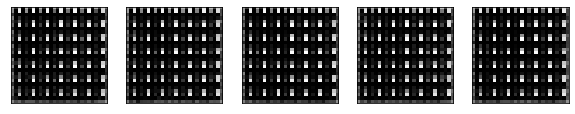

ÉPOCA 007 finalizada: custo discriminador 1.386294 - custo gerador 0.693147      


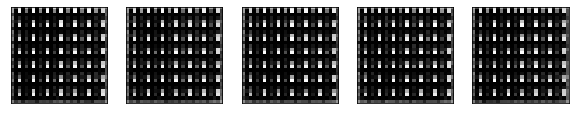

ÉPOCA 008 finalizada: custo discriminador 1.386294 - custo gerador 0.693147      


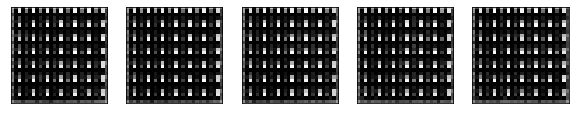

KeyboardInterrupt: 

In [90]:
for epoch in range(100):
    D_running_loss = 0
    G_running_loss = 0
    
    for i, (imagens_reais, _) in enumerate(train_loader):
        batch_size = imagens_reais.size(0)
        imagens_reais = imagens_reais * 2 - 1
        imagens_reais = imagens_reais.to(device)

        # Treinamento do gerador
        G_optimizer.zero_grad()
        ruido = np.random.uniform(low=-1., high=1., size=(batch_size, 100))
        ruido = torch.from_numpy(ruido).float().to(device)
        imagens_falsas = G.forward(ruido)
        outputs_falsas = D.forward(imagens_falsas)
        labels_falsas = torch.ones(batch_size).to(device)
        G_loss = criterion(outputs_falsas.view(*labels_falsas.shape), labels_falsas)
        G_loss.backward()
        G_optimizer.step()

        # Treinamento do discriminador
        D_optimizer.zero_grad()
        outputs_reais = D.forward(imagens_reais)
        labels_reais = (torch.ones(batch_size) * 0.9).to(device)
        D_loss_reais = criterion(outputs_reais.view(*labels_reais.shape), labels_reais)

        ruido = np.random.uniform(-1., 1., (batch_size, 100))
        ruido = torch.from_numpy(ruido).float().to(device)
        imagens_falsas = G.forward(ruido)
        outputs_falsas = D.forward(imagens_falsas)
        labels_falsas = torch.zeros(batch_size).to(device)
        D_loss_falsas = criterion(outputs_falsas.view(*labels_falsas.shape), labels_falsas)

        D_loss = D_loss_reais + D_loss_falsas
        D_loss.backward()
        D_optimizer.step()

        D_running_loss += D_loss.item()
        G_running_loss += G_loss.item()

        # Imprimindo os dados referentes a esse batch   
        print('\rÉpoca {:03d} - Loop {:3d} de {:3d}: custo discriminador {:03.5f} - custo gerador {:03.5f}'.format(epoch + 1, i + 1, len(train_loader), D_loss.item(), G_loss.item()), end = '\r')
  
    # Imprimindo os dados referentes a essa época
    D_running_loss /= len(train_loader)
    G_running_loss /= len(train_loader)
    print('ÉPOCA {:03d} finalizada: custo discriminador {:03.6f} - custo gerador {:03.6f}      '.format(epoch + 1, D_running_loss, G_running_loss))

    fig, ax = plt.subplots(1, 5, figsize=(10,5))
    for i in range(5):
      ax[i].imshow(imagens_falsas.cpu().detach().numpy()[i].reshape(28, 28), cmap='gray')
      ax[i].xaxis.set_visible(False)
      ax[i].yaxis.set_visible(False)
    plt.show()


In [ ]:
ruido = np.random.uniform(-1.,1.,(20,100))
ruido

array([[ 0.09627281, -0.22931646, -0.22281371, ...,  0.23185661,
        -0.47035463,  0.34246961],
       [-0.01959923, -0.07935043,  0.58052762, ...,  0.90420666,
         0.36645709, -0.70452315],
       [-0.03099201,  0.89999355,  0.82590436, ..., -0.9046695 ,
        -0.8607478 , -0.6645153 ],
       ...,
       [-0.09313561,  0.00380102, -0.92761963, ...,  0.72400885,
        -0.42380205, -0.9830512 ],
       [ 0.67560773, -0.07145901, -0.77177724, ..., -0.58138419,
        -0.56881504,  0.28902326],
       [ 0.62236176, -0.02835497, -0.8464849 , ..., -0.17997566,
        -0.86126757,  0.85644742]])

In [ ]:
ruido[0]

array([ 0.09627281, -0.22931646, -0.22281371,  0.34258961, -0.46877481,
       -0.93912966, -0.33922093, -0.29592175,  0.35165127,  0.00869346,
       -0.94871405, -0.56934243, -0.76850243,  0.3710817 ,  0.68994263,
       -0.28443983,  0.41715233,  0.44742001, -0.42140068, -0.12011126,
        0.27684944, -0.46498294,  0.96948422, -0.37848529,  0.47216019,
       -0.05745541,  0.12432141, -0.47075055, -0.61341477, -0.40884055,
       -0.3267186 , -0.68051731, -0.80931354, -0.06524662,  0.96123522,
       -0.66735554,  0.83129182, -0.03008927, -0.01036784,  0.83843154,
        0.83106293, -0.03025305,  0.78621006, -0.3163192 ,  0.17156363,
        0.1354662 ,  0.76851248,  0.87630246, -0.47304026,  0.26551055,
        0.25699838, -0.02541664,  0.78374683,  0.81883381,  0.82263682,
       -0.82839141, -0.92795937, -0.45563655, -0.13837879,  0.51012432,
        0.21117415,  0.71838278,  0.8339181 , -0.70834919, -0.96153054,
       -0.50928708, -0.5210356 , -0.65578525, -0.88392308,  0.30

In [ ]:
ruido = torch.from_numpy(ruido).float().to(device)
ruido

tensor([[ 0.0963, -0.2293, -0.2228,  ...,  0.2319, -0.4704,  0.3425],
        [-0.0196, -0.0794,  0.5805,  ...,  0.9042,  0.3665, -0.7045],
        [-0.0310,  0.9000,  0.8259,  ..., -0.9047, -0.8607, -0.6645],
        ...,
        [-0.0931,  0.0038, -0.9276,  ...,  0.7240, -0.4238, -0.9831],
        [ 0.6756, -0.0715, -0.7718,  ..., -0.5814, -0.5688,  0.2890],
        [ 0.6224, -0.0284, -0.8465,  ..., -0.1800, -0.8613,  0.8564]])

In [ ]:
G.eval()
previsao = G.forward(ruido)

In [ ]:
previsao[0]

tensor([[-0.9836, -0.9447, -0.9887, -0.9483, -0.9912, -0.9965, -0.8426, -0.9717,
         -0.9823, -0.9833, -0.9769, -0.9785, -0.9824, -0.9555, -0.9691, -0.9931,
         -0.9078, -0.8455, -0.9901, -0.9919, -0.9957, -0.9814, -0.9668, -0.9914,
         -0.9750, -0.9872, -0.9818, -0.9708],
        [-0.9824, -0.9856, -0.9797, -0.9936, -0.9851, -0.9807, -0.9558, -0.9549,
         -0.9773, -0.9872, -0.9737, -0.9900, -0.9838, -0.9909, -0.9837, -0.9758,
         -0.9777, -0.9731, -0.9834, -0.9873, -0.9908, -0.9931, -0.9867, -0.9761,
         -0.9911, -0.9915, -0.8681, -0.9855],
        [-0.9941, -0.9923, -0.9820, -0.9565, -0.9899, -0.9263, -0.9492, -0.9914,
         -0.9867, -0.9750, -0.9859, -0.8244, -0.9862, -0.8873, -0.9095, -0.9409,
         -0.9674, -0.8513, -0.9911, -0.9540, -0.9804, -0.8791, -0.9873, -0.9490,
         -0.9834, -0.9835, -0.9943, -0.9644],
        [-0.9769, -0.9864, -0.9914, -0.9862, -0.9849, -0.9792, -0.9865, -0.9915,
         -0.9870, -0.9678, -0.9866, -0.9839, -0.9841

In [ ]:
previsao = previsao.cpu().detach().numpy()

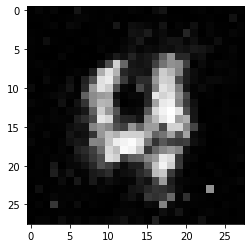

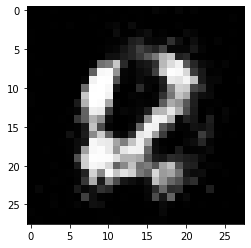

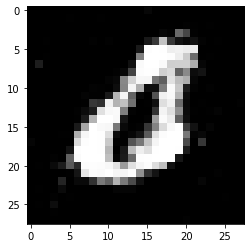

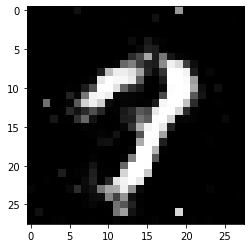

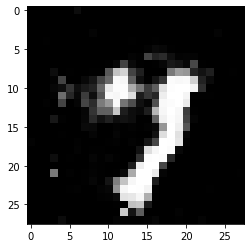

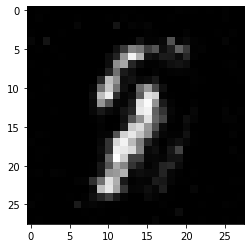

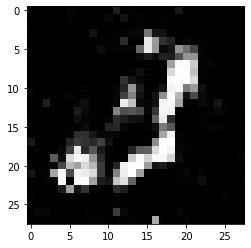

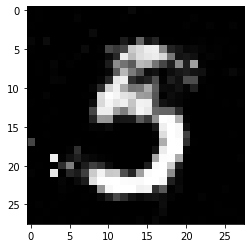

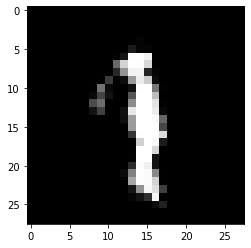

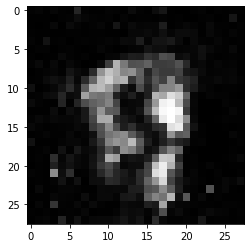

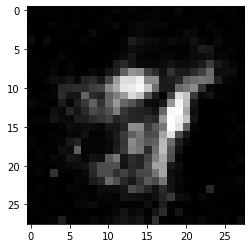

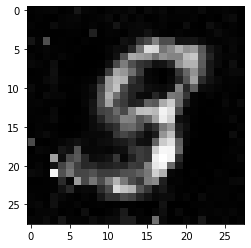

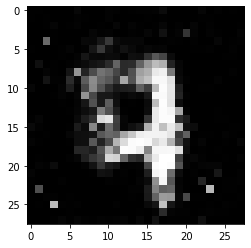

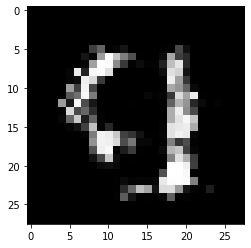

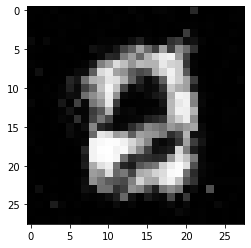

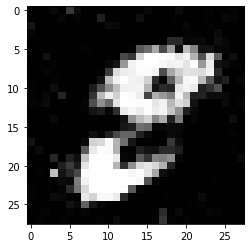

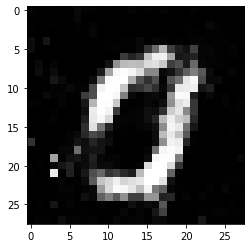

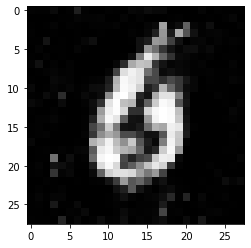

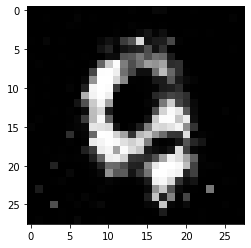

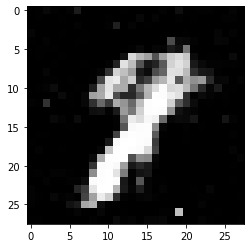

In [ ]:
for i in range(previsao.shape[0]):
    plt.imshow(previsao[i,:].squeeze(), cmap='gray')
    plt.show()